# PbS spectra and PCA


Попробуем разделить наш скудный набор на часть для обучения и тестирования, и не будем выкидывать плохие данные (и то их мало :) )

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA as sk_pca
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from matplotlib.colors import ListedColormap

from scipy.signal import savgol_filter
import seaborn as sns

Спектры из папки ./data ранее были помещены в один файл pbs.csv, нормированы и дополнены нулями (так как они сняты в разном спектральном диапазоне).

Сделаем два набора - сглаженные данные и сглаженные производные. 

In [2]:
data = pd.read_csv('./data/pbs.csv')

# The last column of the Data Frame contains the labels
lab = data.values[1:-1,-1].astype('uint8') 
# потому что для теста ниже взяты первый и последний спектры test = nfeat1[[0,-1],:]
        
# Read the features (scans) 
feat = data.values[1:-1,1:-1]

# Calculate first derivative applying a Savitzky-Golay and median filters
feat = savgol_filter(feat, window_length=15, polyorder=3, deriv=0)
dfeat = savgol_filter(feat, window_length=15, polyorder=3, deriv=1)

Построим спектры, которые планируется анализировать

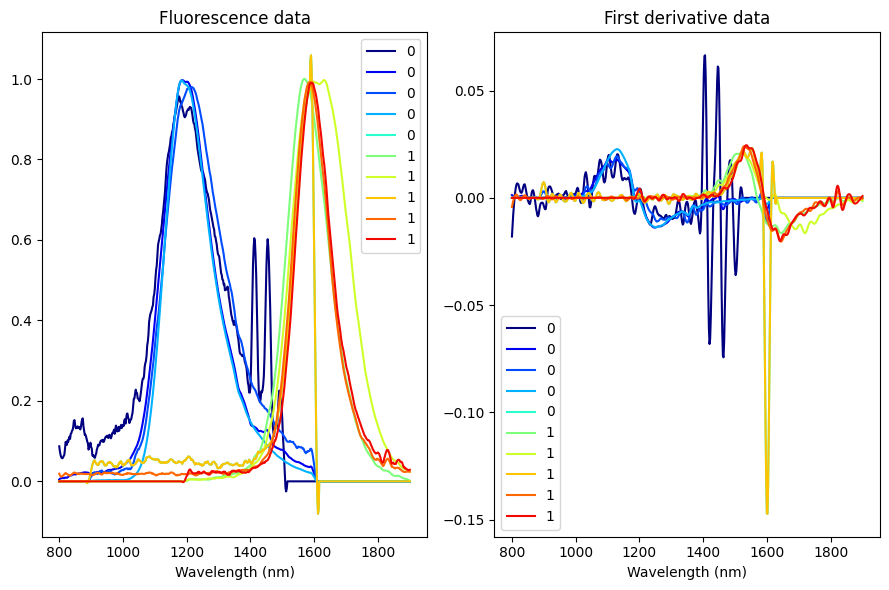

In [3]:
samples = feat.shape[0]
colors = [plt.cm.jet(float(i)/samples) for i in range(samples)]


fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9,6))
fig.set_tight_layout(True)

x = range(800, 1901, 2)

for i in range(samples):
    col = np.expand_dims(np.array(colors[i]), axis=0)
    ax1.plot(x, feat[i,:], c=col, label=lab[i])
ax1.set_xlabel("Wavelength (nm)")
ax1.set_title('Fluorescence data')
ax1.legend()


for i in range(samples):
    col = np.expand_dims(np.array(colors[i]), axis=0)
    ax2.plot(x, dfeat[i,:], c=col, label=lab[i])
ax2.set_xlabel("Wavelength (nm)")
ax2.set_title('First derivative data')
ax2.legend()

plt.show()

Теперь два набора разбираем на принципиальные компоненты.

Для теста берем нулевой и последний, точно разные вещества.

Тогда для обучения надо брать с первого по предпоследний.

In [4]:
# Scale the features to have zero mean and standard devisation of 1
# This is important when correlating data with very different variances
train1 = StandardScaler().fit_transform(feat[1:-1,:])
test1 = StandardScaler().fit_transform(feat[[0,-1],:])

lab_train = lab[1:-1]

train2 = StandardScaler().fit_transform(dfeat[1:-1,:])
test2 = StandardScaler().fit_transform(dfeat[[0,-1],:]) 

 # сколько компонент имеет смысл?

# Initialise
skpca1 = sk_pca(n_components=8)
skpca2 = sk_pca(n_components=8)

Смотрим какое число компонент оптимально для того и другого набора...

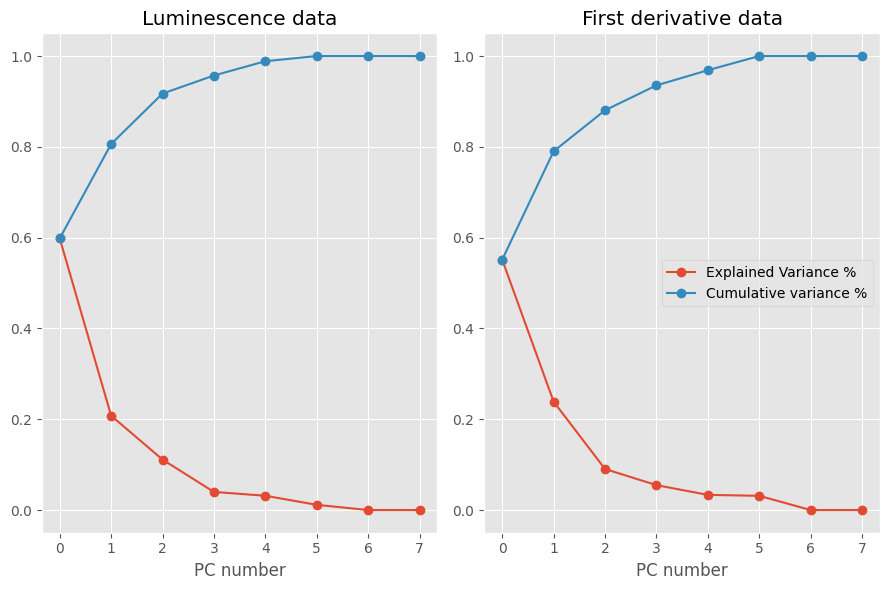

In [5]:
# Fit the spectral data and extract the explained variance ratio
X1 = skpca1.fit(train1)
expl_var_1 = X1.explained_variance_ratio_
 
# Fit the first data and extract the explained variance ratio
X2 = skpca2.fit(train2)
expl_var_2 = X2.explained_variance_ratio_

# Plot data
with plt.style.context(('ggplot')):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9,6))
    fig.set_tight_layout(True)
 
    ax1.plot(expl_var_1,'-o', label="Explained Variance %")
    ax1.plot(np.cumsum(expl_var_1),'-o', label = 'Cumulative variance %')
    ax1.set_xlabel("PC number")
    ax1.set_title('Luminescence data')
 
    ax2.plot(expl_var_2,'-o', label="Explained Variance %")
    ax2.plot(np.cumsum(expl_var_2),'-o', label = 'Cumulative variance %')
    ax2.set_xlabel("PC number")
    ax2.set_title('First derivative data')
 
    plt.legend()
    plt.show()

Running the Classification of spectra using PCA

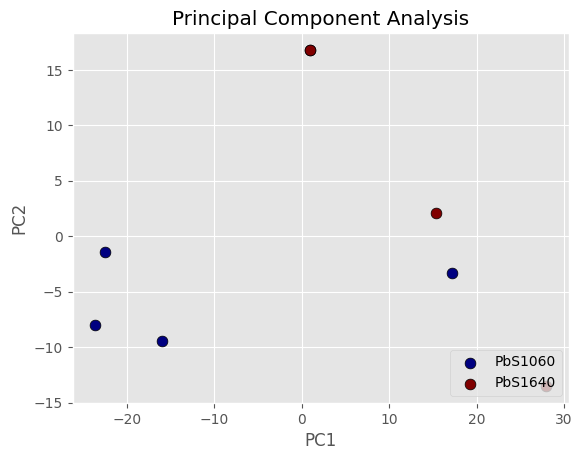

In [6]:
#подставить смотря что считается - спектр train1 или производная train2 и соответствующий тест:
nfeat = train1
test = test1


skpca2 = sk_pca(n_components=2) #3
 
# Transform on the scaled features
Xt2 = skpca2.fit_transform(nfeat)

# Define the labels for the plot legend
labplot = ["PbS1060","PbS1640"]
 
# Scatter plot
unique = list(set(lab))
colors = [plt.cm.jet(float(i)/max(unique)) for i in unique]
with plt.style.context(('ggplot')):
    for i, u in enumerate(unique):
        col = np.expand_dims(np.array(colors[i]), axis=0)
        xi = [Xt2[j,0] for j in range(len(Xt2[:,0])) if lab[j] == u]
        yi = [Xt2[j,1] for j in range(len(Xt2[:,1])) if lab[j] == u]
        plt.scatter(xi, yi, c=col, s=60, edgecolors='k',label=str(u))
 
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.legend(labplot,loc='lower right')
    plt.title('Principal Component Analysis')
    plt.show()

Layered kernel density estimate (KDE)  

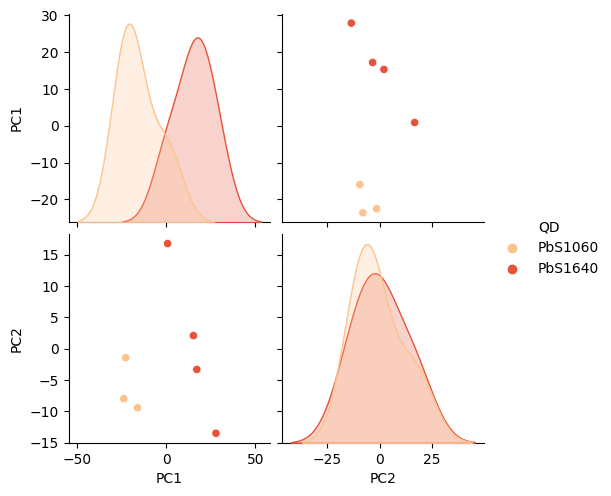

In [7]:
# https://nirpyresearch.com/nir-data-correlograms-seaborn-python/     
df = pd.DataFrame(Xt2, columns=['PC1', 'PC2'])
#df = pd.DataFrame(Xt2, columns=['PC1', 'PC2', 'PC3'])

y_train = lab_train.T.astype("int")

df["QD"] = y_train
df['QD'] = df['QD'].replace([0], 'PbS1060')
df['QD'] = df['QD'].replace([1], 'PbS1640')
sns.pairplot(df, hue="QD", palette='OrRd')
plt.show()

## логистическая регрессия - классификация и предсказание

 https://www.geeksforgeeks.org/principal-component-analysis-with-python/


Оценка совпадения предсказаний:  [[1 0]
 [0 1]]


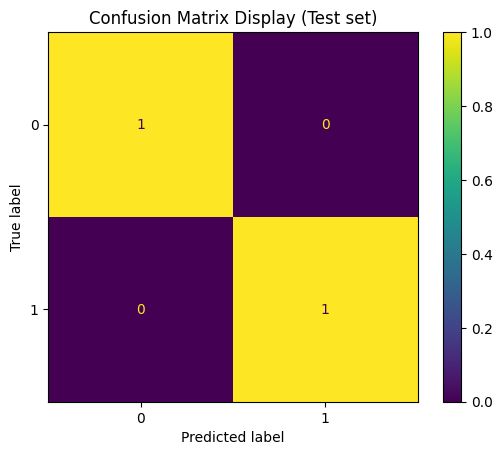

In [8]:
# Fitting Logistic Regression To the training set
classifier = LogisticRegression(random_state = 0)
classifier.fit(Xt2, y_train)


# Predicting the test set result 
x_test = skpca2.transform(test)
y_pred = classifier.predict(x_test)
y_test = lab[[0, -1]]

# Making the confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
 
cm = confusion_matrix(y_test, y_pred)
print('Оценка совпадения предсказаний: ', cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
disp.plot()
plt.title('Confusion Matrix Display (Test set)')
plt.show()

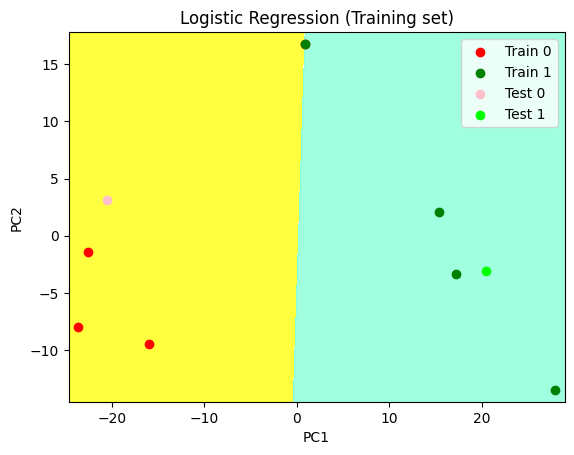

In [9]:
# Predicting the training set result

x_set, y_set = Xt2, y_train

X1, X2 = np.meshgrid(np.arange(start = x_set[:, 0].min() - 1,
                     stop = x_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = x_set[:, 1].min() - 1,
                     stop = x_set[:, 1].max() + 1, step = 0.01))
  
plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(),
             X2.ravel()]).T).reshape(X1.shape), alpha = 0.75,
             cmap = ListedColormap(('yellow', 'white', 'aquamarine')))
  
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
  
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(x_set[y_set == j, 0], x_set[y_set == j, 1],
                color = ListedColormap(('red', 'green'))(i), label = 'Train ' + str(j))
                
#  добавим "проверочные" точки на график
for i, j in enumerate(np.unique(y_test)):
    plt.scatter(x_test[y_test == j, 0], x_test[y_test == j, 1],
                color = ListedColormap(('pink', 'lime'))(i), label = 'Test ' + str(j))

  
plt.title('Logistic Regression (Training set)')
plt.xlabel('PC1') # for Xlabel
plt.ylabel('PC2') # for Ylabel
plt.legend() # to show legend
  
# show scatter plot
plt.show()